In [68]:
import pandas as pd
import numpy as np

import re

from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

In [69]:
df = pd.read_csv("Data/listings.csv", sep = ",")

## Data Cleaning

### Dropping listings without price

In [72]:
df.price.isna().sum()

972

In [73]:
df = df.dropna(subset = "price")

### Converting to Numeric Values

In [75]:
# Price

df["price"] = df["price"].apply(lambda x: float(x[1:].replace(",","")) if pd.notna(x) else x)

### Host Features

In [77]:
re_host = "host.*"

host_feat = []

for feat in df.columns:
    if re.match(re_host, feat):
         host_feat.append(feat)

host_drop = ["host_id", "host_url", "host_name", "host_location", "host_about", "host_thumbnail_url", 
             "host_picture_url", "host_neighbourhood", "host_since", "host_listings_count", "host_total_listings_count"]

df = df.drop(host_drop, axis = 1)

### Id Features

In [79]:
re_id = ".*id.*"

id_feat = []

for feat in df.columns:
    if re.match(re_id, feat):
         id_feat.append(feat)

id_drop = ["id", "scrape_id"]

df = df.drop(id_drop, axis = 1)

### Url features

In [81]:
re_url = ".*url.*"

url_feat = []

for feat in df.columns:
    if re.match(re_url, feat):
        url_feat.append(feat)
        
url_drop = ["listing_url", "picture_url"]

df = df.drop(url_drop, axis = 1)

### Number of nights

In [83]:
# minimum_nights
# minimum_minimum_nights
# minimum_maximum_nights
# minimum_nights_avg_ntm

df[[x for x in df.columns if re.match("minimum.*", x)]]

# Values are pretty much the same (differnce = 0)
print(df.apply(lambda x: x["minimum_nights"] - x["minimum_minimum_nights"], axis = 1).value_counts())

#Values are prettu much all captured with minimum_nights and maximum_nights
drop_min_max = ["minimum_minimum_nights", "maximum_minimum_nights", "minimum_maximum_nights", "maximum_maximum_nights", "minimum_nights_avg_ntm", "maximum_nights_avg_ntm"]

df = df.drop(drop_min_max, axis = 1)

 0      29875
 1       1965
 2        708
-1        430
 3        225
        ...  
 30         1
 70         1
 199        1
-88         1
 87         1
Name: count, Length: 70, dtype: int64


### Others to drop

In [85]:
feat_na = df.isna().sum()

feat_na[feat_na > 0].sort_values()

bathrooms                          23
beds                               24
bedrooms                           38
bathrooms_text                     39
has_availability                  292
host_is_superhost                 833
description                      1130
host_acceptance_rate             3431
host_response_time               5605
host_response_rate               5605
review_scores_rating             8090
last_review                      8090
first_review                     8090
reviews_per_month                8090
review_scores_accuracy           8099
review_scores_cleanliness        8099
review_scores_checkin            8099
review_scores_communication      8099
review_scores_location           8099
review_scores_value              8101
neighbourhood                   17123
neighborhood_overview           17123
neighbourhood_group_cleansed    33692
license                         33692
calendar_updated                33692
dtype: int64

In [86]:
feat_not_relevant = ["last_scraped", "source", "first_review", "last_review", "license", "neighbourhood",
                     "neighborhood_overview", "neighbourhood_group_cleansed", "name", "description",
                    "calendar_updated", "calculated_host_listings_count", "calculated_host_listings_count_entire_homes",
                    "calculated_host_listings_count_private_rooms", "calculated_host_listings_count_shared_rooms", "calendar_last_scraped"]
# neighbourhood is better represented in neighbourhood_cleansed
df = df.drop(feat_not_relevant, axis = 1)

In [87]:
df.columns

Index(['host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_verifications', 'host_has_profile_pic',
       'host_identity_verified', 'neighbourhood_cleansed', 'latitude',
       'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms',
       'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price',
       'minimum_nights', 'maximum_nights', 'has_availability',
       'availability_30', 'availability_60', 'availability_90',
       'availability_365', 'number_of_reviews', 'number_of_reviews_ltm',
       'number_of_reviews_l30d', 'review_scores_rating',
       'review_scores_accuracy', 'review_scores_cleanliness',
       'review_scores_checkin', 'review_scores_communication',
       'review_scores_location', 'review_scores_value', 'instant_bookable',
       'reviews_per_month'],
      dtype='object')

### Location Analysis

In [89]:
# Chcking for outliers
# Some listing prices are unreal
prices_df = df.price.sort_values(ascending = False)
prices_df[prices_df > 4000].count()

641

In [90]:
df = df.loc[df.price <= 4000, :]
df.price.count()

33051

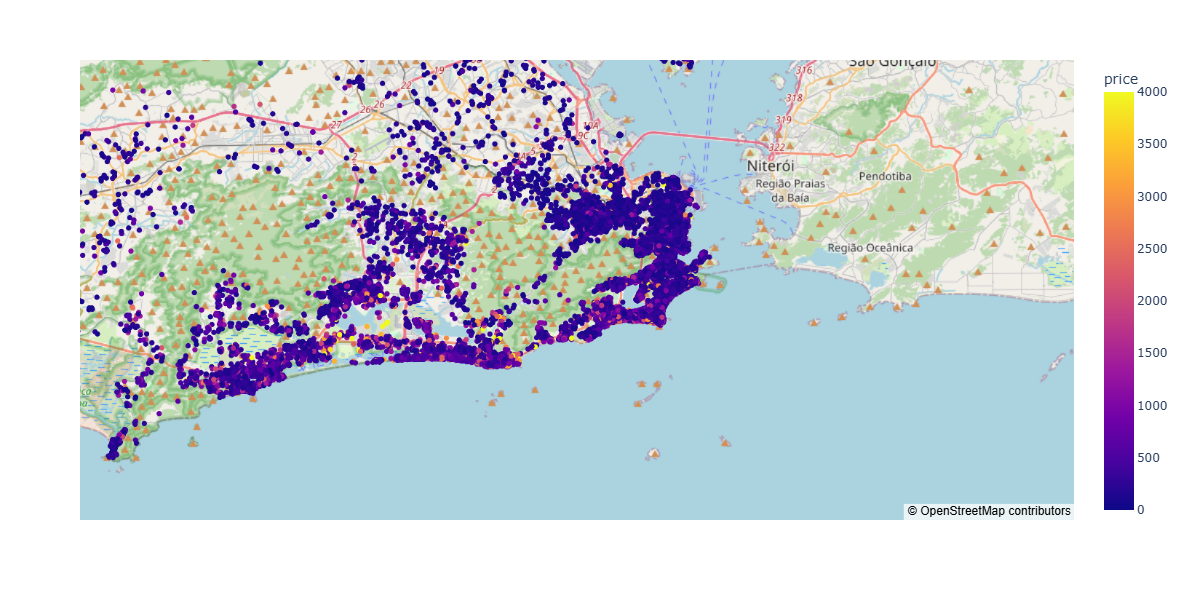

In [91]:
fig = px.scatter_mapbox(df, 
                  lat="latitude", 
                  lon="longitude",     
                  color="price",  
                  size_max=15, 
                  zoom=10,
                  height = 600,
                  mapbox_style = "carto-darkmatter")



fig.update_layout(mapbox_style="open-street-map")

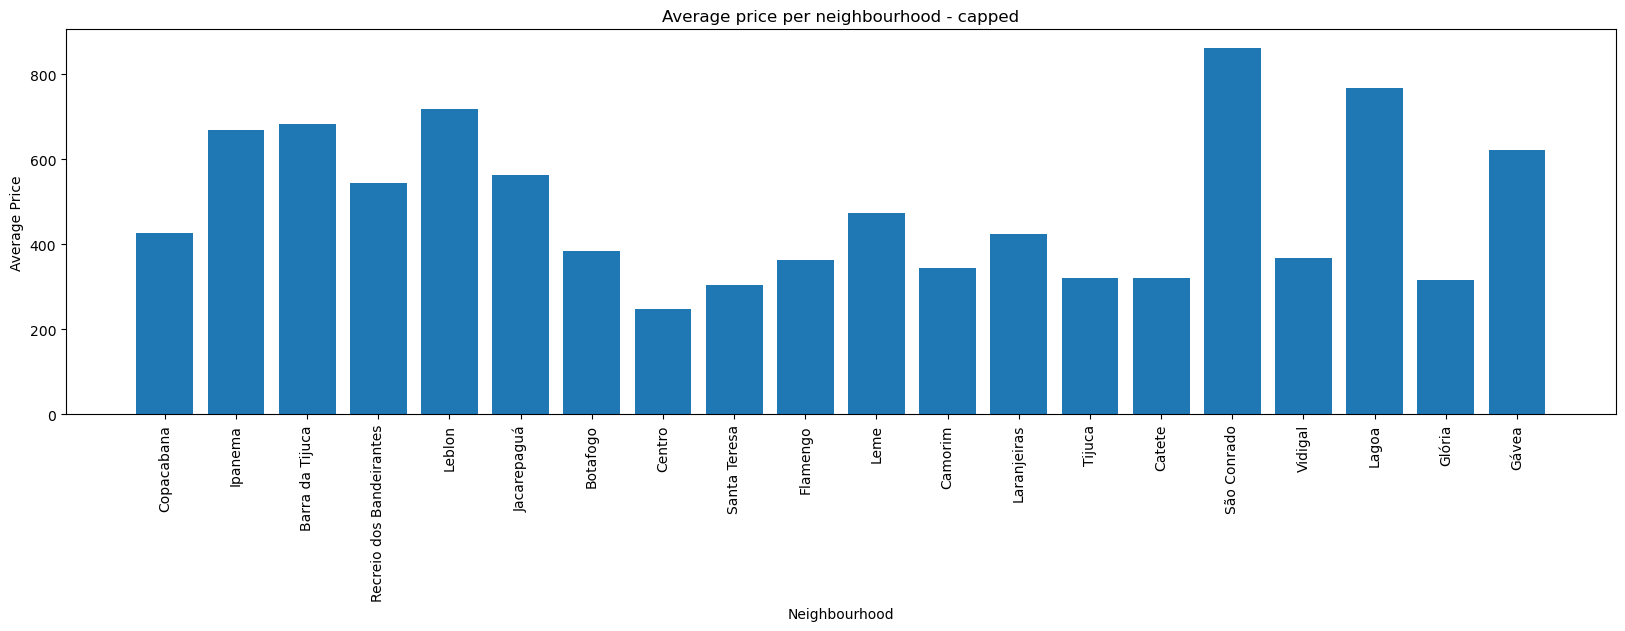

In [92]:
avg_neighbourhood_count = df[["neighbourhood_cleansed", "price"]].groupby("neighbourhood_cleansed").agg(count=('neighbourhood_cleansed','size'),
                                                                              price=('price', 'mean')).sort_values("count", ascending = False)
avg_neighbourhood = avg_neighbourhood_count.loc[avg_neighbourhood_count["count"] > 200].price

plt.figure(figsize=(20, 5))
plt.bar(x = avg_neighbourhood.index, height = avg_neighbourhood)
labels = plt.xticks(rotation=90)

plt.title("Average price per neighbourhood - capped")
plt.ylabel("Average Price")
plt.xlabel("Neighbourhood")

plt.show()

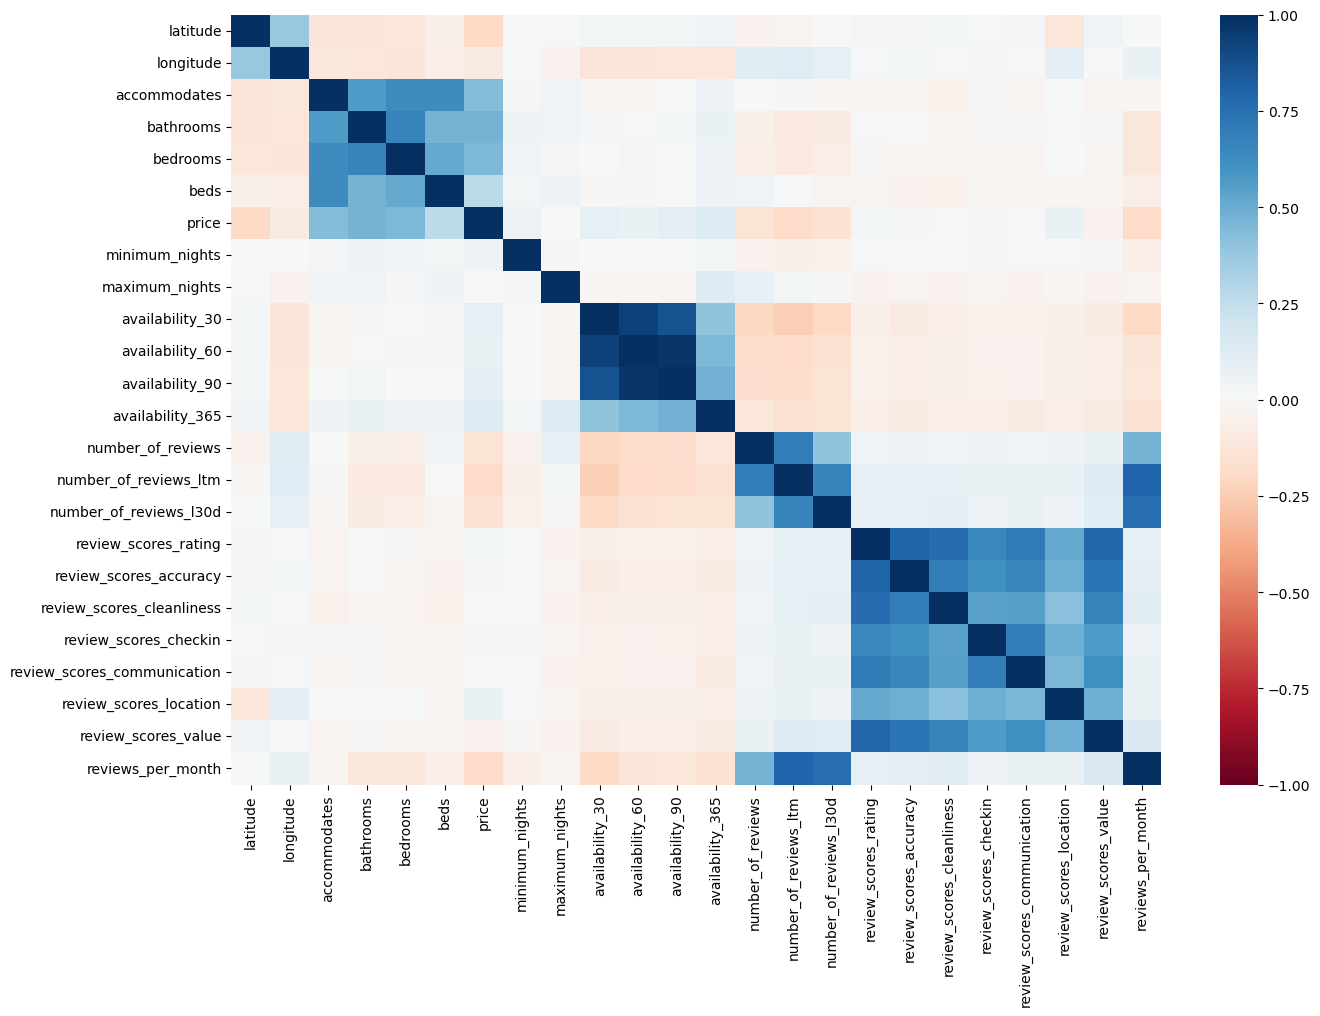

In [93]:
plt.figure(figsize=(15,10))
correlations = df.corr(numeric_only=True)
sns.heatmap(round(correlations,2), cmap='RdBu', annot=False, 
            annot_kws={"size": 7}, vmin=-1, vmax=1);

In [94]:
# Dropping latitude and longitude
# Info alaready capture with the division into different neighbourhoods
df = df.drop(["longitude", "latitude"], axis = 1)

In [95]:
# NUmber of review ltm vs price

df.corr(numeric_only = True)["price"].sort_values(ascending = False, key = abs)

price                          1.000000
bathrooms                      0.467835
bedrooms                       0.451879
accommodates                   0.431100
beds                           0.267647
number_of_reviews_ltm         -0.191492
reviews_per_month             -0.185721
number_of_reviews_l30d        -0.154713
number_of_reviews             -0.139841
availability_365               0.137547
availability_90                0.096370
availability_30                0.093654
availability_60                0.074117
review_scores_location         0.066531
minimum_nights                 0.050101
review_scores_value           -0.038647
review_scores_rating           0.029819
review_scores_checkin          0.022637
review_scores_accuracy         0.017257
review_scores_communication    0.008664
review_scores_cleanliness      0.007936
maximum_nights                 0.000643
Name: price, dtype: float64

In [96]:
# Dropping features not relevant for the problem:

# availability_365
# host_is_superhost
# minimum_nights
# has_availability

drop_feat = ["availability_365", "minimum_nights", 
             "maximum_nights", "availability_30", 
             "availability_60", "availability_90"]

df = df.drop(drop_feat, axis = 1)

In [97]:
# Dropping reviews with lower correlation

# number_of_reviews_ltm
# number_of_reviews_l30d
# number_of_reviews
# review_scores_value
# review_scores_rating
# review_scores_accuracy
# review_scores_checkin
# review_scores_cleanliness
# review_scores_communication
# review_scores_location   
# reviews_per_month

drop_reviews = ["number_of_reviews_ltm", "number_of_reviews_l30d", "number_of_reviews",
               "review_scores_value", "review_scores_rating", "review_scores_accuracy",
               "review_scores_checkin", "review_scores_cleanliness", "review_scores_communication",
               "review_scores_location" ,"reviews_per_month"]

df = df.drop(drop_reviews, axis = 1)

In [98]:
print(df.isna().sum())

#df = df.dropna()

host_response_time        5401
host_response_rate        5401
host_acceptance_rate      3222
host_is_superhost          824
host_verifications           0
host_has_profile_pic         0
host_identity_verified       0
neighbourhood_cleansed       0
property_type                0
room_type                    0
accommodates                 0
bathrooms                   23
bathrooms_text              38
bedrooms                    37
beds                        24
amenities                    0
price                        0
has_availability           286
instant_bookable             0
dtype: int64


### Categorical Data

In [100]:
#Low correlation
low_corr = ["has_availability", "instant_bookable"]

df = df.drop(low_corr, axis = 1)

In [101]:
# Drop Response/Acceptance rate
df = df.drop(["host_response_rate", "host_acceptance_rate", "host_is_superhost"], axis = 1)

In [102]:
# Removing low correlations 
low_corr = ["host_has_profile_pic", "host_identity_verified"]
df = df.drop(low_corr, axis = 1)

### Dealing with Nans

In [104]:
df.isna().sum()

host_response_time        5401
host_verifications           0
neighbourhood_cleansed       0
property_type                0
room_type                    0
accommodates                 0
bathrooms                   23
bathrooms_text              38
bedrooms                    37
beds                        24
amenities                    0
price                        0
dtype: int64

In [105]:
# host_response_time

df.isna().sum()

le = LabelEncoder()

copy_df = pd.DataFrame()
copy_df["host_response_time"] = le.fit_transform(df.host_response_time)
copy_df["price"] = df.price

#host_response_time does not correlate to the price
# We solve the Nan problem as well
print(copy_df.corr())

df = df.drop("host_response_time", axis = 1)

                    host_response_time     price
host_response_time            1.000000  0.005059
price                         0.005059  1.000000


In [106]:
# bathrooms - contains the same information about the number of bathrooms as bathrooms_text
# bathrooms_text - keeping this feature for later extraction of private/shared bathroom information. It will be dropped later

df = df.dropna(subset = "bathrooms")

In [107]:
# bedrooms - cannot impute the value based on the dataset. So dropping all these nas
# beds - same reason for beds

df = df.dropna(subset = ["bedrooms", "beds"])

In [108]:
# property_type: being dropped for now due to the variety of values. Revisit later (!)
# host_verifications: being dropped for now due to the variety of values. Revisit later (!)

df = df.drop(["property_type", "host_verifications"], axis = 1)

In [109]:
df.isna().sum()

neighbourhood_cleansed     0
room_type                  0
accommodates               0
bathrooms                  0
bathrooms_text            15
bedrooms                   0
beds                       0
amenities                  0
price                      0
dtype: int64

# Encoding these binary features (0-1)

label_encoding_list = ["host_is_superhost", "host_identity_verified", "has_availability", "instant_bookable"]

le = LabelEncoder()

for feat in label_encoding_list:
    df[feat] = le.fit_transform(df[feat])

##### Encoding room_type

In [112]:
print(df.room_type.value_counts())

#Remove Hotel Rooms and Shared Roms (outliers)
df = df.loc[(df.room_type != "Hotel room") &
            (df.room_type != "Shared room"), :]

# Label Encode room_type category (binary value 0/1)
le = LabelEncoder()
df["is_entire_home"] = le.fit_transform(df["room_type"])

df = df.drop("room_type", axis = 1)

room_type
Entire home/apt    25952
Private room        6420
Shared room          572
Hotel room            24
Name: count, dtype: int64


##### Extracting private/share bathroom information

In [114]:
df.bathrooms_text.unique()

# Create columns with shared bath boolean and another with number of bathrooms

    
def bathroom_number(a_bath):

    number_bath = 0 #default value
    is_shared = 0 #default value
    
    # Handling missing values
    if(pd.isna(a_bath)):

        number_bath = np.nan
        is_shared = np.nan
    else:

        #Split the bathroom string
        bath_split = a_bath.split()    

        try:
            #Case has-a-number
            number_bath = float(bath_split[0])   #If element not a number it will execute the exception code

           
            #Case has-a-number + shared
            if(re.match(".*shared.*", str.lower(a_bath))):
                is_shared = 1

        except:
            #Case dont-have-number
            if(re.match(".*half-bath.*", str.lower(a_bath))):
                number_bath = 0.5
            #Case dont-have-number + shared
            if(re.match(".*shared.*", str.lower(a_bath))):
                is_shared = 1  
          
 
    return number_bath, is_shared
            
    

df[["number_bathroom", "is_bathroom_shared"]] = df["bathrooms_text"].apply(lambda x: pd.Series(bathroom_number(x)))

# Dropping original feature wwith number and shared info
df = df.drop(["bathrooms_text", "number_bathroom"], axis = 1)

## !! number_bathroom is reduntant since this info is already in the "bathroom" feature

In [115]:
# Recover this information from is_entire_home.
# If the apartment is private (all for the renter) then the toilet is ASSUMED to be private too
df.loc[df["is_bathroom_shared"].isna(), "is_bathroom_shared"] = df.loc[df["is_bathroom_shared"].isna(), "is_entire_home"].apply(lambda x: abs(x-1))

In [116]:
df.isna().sum()

neighbourhood_cleansed    0
accommodates              0
bathrooms                 0
bedrooms                  0
beds                      0
amenities                 0
price                     0
is_entire_home            0
is_bathroom_shared        0
dtype: int64

##### Extracting amenities information

In [118]:
df.amenities.iloc[50]

'["Kitchen", "Refrigerator", "Bed linens", "Dishes and silverware", "Heating", "Dedicated workspace", "Essentials", "TV with standard cable", "Cooking basics", "Air conditioning", "Host greets you", "Wifi", "Microwave", "Window guards", "Elevator", "Coffee maker", "Washer"]'

In [119]:

# Convert the amenities string into a list of amenities
def add_amenities_to_set(amenities):
    amenities_proc = amenities.replace("[", "").replace("]", "").replace('"', "")
    amenitites_splitted = amenities_proc.split(", ")
    features.update(amenitites_splitted)

######################################################
#List of amenities being considered (TO BE REVISED !)#
######################################################
amenities_list_re = { "parking": ".*parking on premises.*", 
                     "pool":".*pool.*", 
                     "ac1": ".*air conditioning.*",
                     "ac2":".* ac .*",
                     "tv": ".*tv.*",
                     "washer":".*washer.*",
                     "balcony":".*balcony.*",
                     "kitchen":".*kitchen.",
                     "beach access": ".*beach access.*"
                      }
        
    
#Create the has_amenities columns
has_amn_feat = ["has_" + x for x in amenities_list_re.keys()]

#Default value 0 (does not have amenity)
df[has_amn_feat] = 0


def convert_amenities(amenities, index): 
    for amn_name, amn_re in amenities_list_re.items():
        if(re.match(amn_re, str.lower(amenities))):
  
            df.loc[index,"has_"+ amn_name] = 1

for index, row in df.iterrows():
    convert_amenities(df.loc[index, "amenities"], index)

# Merge ac1 and ac2
df["has_ac"] = df.apply(lambda x: (x["has_ac1"] or x["has_ac2"]), axis = 1)

# Drop aac1 and ac2 and amenities features
df = df.drop(["has_ac1", "has_ac2", "amenities"], axis = 1)

In [120]:
df_categorical = df.select_dtypes(include = 'object')
df_categorical

neighbourhood_cleansed
0                 Copacabana
1                 Copacabana
2                     Tijuca
3                 Copacabana
4                    Ipanema
...                      ...
34659             Copacabana
34660               Botafogo
34661                 Leblon
34662             Copacabana
34663                  Lagoa

[32372 rows x 1 columns]

In [121]:
# Confirming the absence of missing values
df.isna().sum()

neighbourhood_cleansed    0
accommodates              0
bathrooms                 0
bedrooms                  0
beds                      0
price                     0
is_entire_home            0
is_bathroom_shared        0
has_parking               0
has_pool                  0
has_tv                    0
has_washer                0
has_balcony               0
has_kitchen               0
has_beach access          0
has_ac                    0
dtype: int64

### Outliers

In [123]:
df.describe()

accommodates     bathrooms      bedrooms          beds         price  \
count  32372.000000  32372.000000  32372.000000  32372.000000  32372.000000   
mean       3.929692      1.495258      1.522612      2.186272    492.788212   
std        2.149476      0.852766      0.978002      1.819381    531.748680   
min        1.000000      0.000000      0.000000      0.000000      0.000000   
25%        2.000000      1.000000      1.000000      1.000000    200.000000   
50%        4.000000      1.000000      1.000000      2.000000    304.500000   
75%        5.000000      2.000000      2.000000      3.000000    550.000000   
max       16.000000     20.000000     30.000000     50.000000   4000.000000   

       is_entire_home  is_bathroom_shared   has_parking      has_pool  \
count     32372.00000        32372.000000  32372.000000  32372.000000   
mean          0.19832            0.070369      0.363215      0.241289   
std           0.39874            0.255773      0.480934      0.427872   
min           0.00000            0.000000      0.000000      0.000000   
25%           0.00000            0.000000      0.000000      0.000000   
50%           0.00000            0.000000      0.000000      0.000000   
75%           0.00000            0.000000      1.000000      0.000000   
max           1.00000            1.000000      1.000000      1.000000   

             has_tv    has_washer   has_balcony   has_kitchen  \
count  32372.000000  32372.000000  32372.000000  32372.000000   
mean       0.892963      0.619671      0.209317      0.916749   
std        0.309165      0.485475      0.406827      0.276265   
min        0.000000      0.000000      0.000000      0.000000   
25%        1.000000      0.000000      0.000000      1.000000   
50%        1.000000      1.000000      0.000000      1.000000   
75%        1.000000      1.000000      0.000000      1.000000   
max        1.000000      1.000000      1.000000      1.000000   

       has_beach access        has_ac  
count      32372.000000  32372.000000  
mean           0.445632      0.709687  
std            0.497043      0.453914  
min            0.000000      0.000000  
25%            0.000000      0.000000  
50%            0.000000      1.000000  
75%            1.000000      1.000000  
max            1.000000      1.000000

In [124]:
# Max number of neighborhoods we are considering
max_neighbourhood = 20

# Group the dataset by neighbourhood and count how many properties for each neighbourhood
df_count_neighbourhood = df.groupby("neighbourhood_cleansed").size().reset_index(name = "count").sort_values(by = "count", ascending = False)


# Select only the #max_neighbourhood neighbourhoods with the most properties
list_of_neighbourhood = df_count_neighbourhood.head(max_neighbourhood).neighbourhood_cleansed.unique()

# Filter the dataset to contain only those neighbourhoods, eliminating the outliers
df = df.loc[df["neighbourhood_cleansed"].isin(list_of_neighbourhood), :]

In [125]:
# Remove instances where value for beds and bedrooms are both 0
#df.loc[(df["bedrooms"] == 0) & (df["beds"] == 0), :].count()

df = df.loc[(df["bedrooms"] != 0) & (df["beds"] != 0), :]

In [126]:
df.corr(numeric_only = True).price

accommodates          0.429561
bathrooms             0.504467
bedrooms              0.480073
beds                  0.337820
price                 1.000000
is_entire_home       -0.180173
is_bathroom_shared   -0.125594
has_parking           0.213990
has_pool              0.201810
has_tv                0.077245
has_washer            0.155960
has_balcony           0.052636
has_kitchen           0.056876
has_beach access     -0.039560
has_ac                0.098522
Name: price, dtype: float64

### Binary Encoding option

In [128]:
import category_encoders as ce
bin_encoder = ce.BinaryEncoder(cols = 'neighbourhood_cleansed' , return_df = True)

df_bin = bin_encoder.fit_transform(df.drop("price", axis = 1))

### Label Encoding

In [130]:
from sklearn import preprocessing 

label_encoder = preprocessing.LabelEncoder() 

df_label = df.drop("price", axis = 1).copy(deep = True)
df_label["neighbourhood_cleansed"] = label_encoder.fit_transform(df_label["neighbourhood_cleansed"])

### One-Hod-Encoding option

In [132]:
## Another option could be with get_dummies
from sklearn.preprocessing import OneHotEncoder

onehot_encoder = OneHotEncoder(sparse_output = False)

series_onehot = onehot_encoder.fit_transform(df[["neighbourhood_cleansed"]])

In [133]:
df_onehot = df.drop("price", axis = 1).copy(deep = True)
df_onehot[onehot_encoder.categories_[0]] = series_onehot
df_onehot = df_onehot.drop("neighbourhood_cleansed", axis = 1)

## Normalisation

In [135]:
from sklearn.preprocessing import MinMaxScaler

# Normalise all the 3 types of encoding dataset above
scaler = MinMaxScaler()
df_bin = pd.DataFrame(scaler.fit_transform(df_bin), columns= df_bin.columns, index = df_bin.index)
df_label = pd.DataFrame(scaler.fit_transform(df_label), columns= df_label.columns, index = df_label.index)
df_onehot = pd.DataFrame(scaler.fit_transform(df_onehot), columns= df_onehot.columns, index = df_onehot.index)

df_bin["price"] = df["price"]
df_label["price"] = df["price"]
df_onehot["price"] = df["price"]


### Save all the datasets

In [137]:
df_bin.to_csv("Data/df_bin.csv")
df_label.to_csv("Data/df_label.csv")
df_onehot.to_csv("Data/df_onehot.csv")

In [138]:
#################
# TO BE REVISED #
#################

# Better check the "review" features that were dropped before